In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 12
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((515, 12, 1), (515,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT12/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 10s 124ms/step - loss: 0.5781 - root_mean_squared_error: 0.7603 - val_loss: 0.3901 - val_root_mean_squared_error: 0.6246
Epoch 2/50
53/53 [==============================] - 7s 125ms/step - loss: 0.2059 - root_mean_squared_error: 0.4538 - val_loss: 0.1858 - val_root_mean_squared_error: 0.4310
Epoch 3/50
53/53 [==============================] - 6s 116ms/step - loss: 0.1165 - root_mean_squared_error: 0.3413 - val_loss: 0.1809 - val_root_mean_squared_error: 0.4253
Epoch 4/50
53/53 [==============================] - 6s 115ms/step - loss: 0.1123 - root_mean_squared_error: 0.3352 - val_loss: 0.1750 - val_root_mean_squared_error: 0.4183
Epoch 5/50
53/53 [==============================] - 6s 112ms/step - loss: 0.1087 - root_mean_squared_error: 0.3297 - val_loss: 0.1728 - val_root_mean_squared_error: 0.4157
Epoch 6/50
53/53 [==============================] - 6s 114ms/step - loss: 0.1131 - root_mean_squared_error: 0.3363 - val_loss: 0.1682 - val

53/53 [==============================] - 1s 19ms/step - loss: 0.0416 - root_mean_squared_error: 0.2040 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2143
Epoch 32/50
53/53 [==============================] - 1s 19ms/step - loss: 0.0410 - root_mean_squared_error: 0.2025 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2266
Epoch 33/50
53/53 [==============================] - 1s 20ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2310
Epoch 34/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0380 - root_mean_squared_error: 0.1950 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2205
Epoch 35/50
53/53 [==============================] - 1s 20ms/step - loss: 0.0398 - root_mean_squared_error: 0.1995 - val_loss: 0.0480 - val_root_mean_squared_error: 0.2192
Epoch 36/50
53/53 [==============================] - 6s 109ms/step - loss: 0.0365 - root_mean_squared_error: 0.1911 - val_loss: 0.0393 - val_root_mean_s

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

2.8161248167355857 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

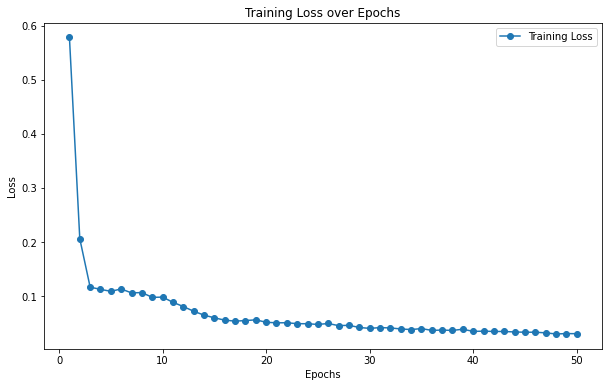

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

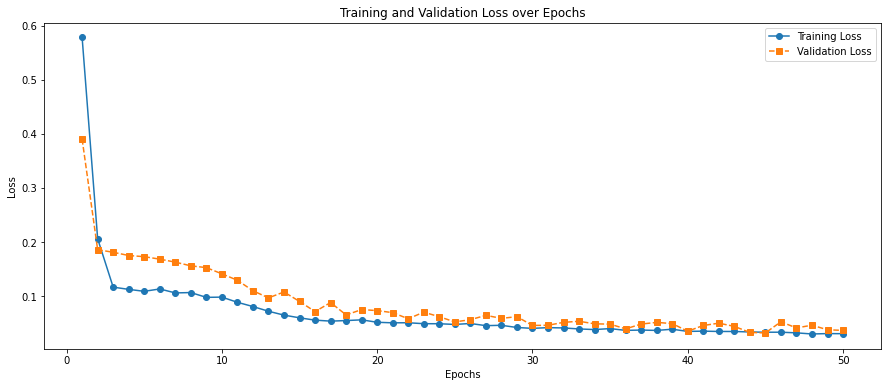

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT12/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 15ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.14596262696455828
MAE : 0.1098879126457319


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,891351.62500,910653.838
1,895540.50000,822319.125
2,740179.68750,557314.102
3,419899.84375,197129.525
4,285121.25000,75730.217
5,242351.15625,59608.479
6,386938.06250,88785.283
7,544777.37500,396883.400
8,716974.75000,662542.207
9,829843.18750,871431.414


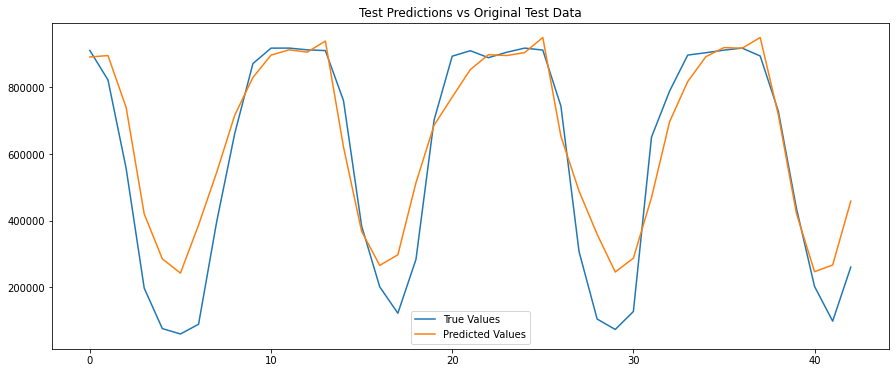

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 11ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

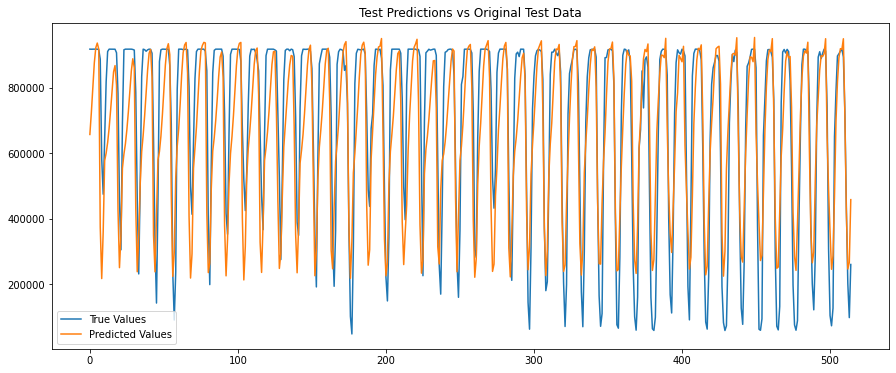

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()